<a href="https://colab.research.google.com/github/Lavkesh-kumar/Solar-panel-Detection/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive

In [2]:
# Prepare folder structure
PROJECT_FOLDER = "/content/drive/MyDrive/Solar panel detection/"
DATA_FOLDER = "/home/data/"
TRAIN_DATA_FOLDER = PROJECT_FOLDER + 'unziped_train/'
TEST_DATA_FOLDER = PROJECT_FOLDER + 'unziped_evaluation/'
SAMPLE_DATA_FOLDER = PROJECT_FOLDER + 'unziped_sample/'

In [3]:
import os
import random
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.transforms import v2

import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install segmentation-models-pytorch

import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [5]:

def load_image_masks(folder_name, file_names):
    image_data = []
    mask_data = []

  # train image path = /gdrive/MyDrive/Solar panel detection/unziped_train/s2_image/train_s2_image_0.tif
  # mask path = /gdrive/MyDrive/Solar panel detection/unziped_train/mask/train_mask_0.tif

    for fn in tqdm(file_names):
        postfix = fn.split("_")[3]
        image_path = f"{folder_name}/s2_image/{fn}"
        mask_path = f"{folder_name}/mask/train_mask_{postfix}"

        # Check if files exist and are not empty
        if os.path.exists(image_path) and os.path.getsize(image_path) > 0:
            image_data.append(tifffile.imread(image_path))
        else:
            print(f"Warning: Image file not found or empty: {image_path}")


        if os.path.exists(mask_path) and os.path.getsize(mask_path) > 0:
            mask_data.append(tifffile.imread(mask_path))
        else:
            print(f"Warning: Mask file not found or empty: {mask_path}")

    return image_data, mask_data

In [22]:
train_image_files = os.listdir(f'{TRAIN_DATA_FOLDER}s2_image/')       #[:100]
train_image_files.remove('train_s2_image_1216.tif')   #because corres.. mask doesn't occur (got from next cell)

# /content/drive/MyDrive/Solar panel detection/unziped_train/s2_image/train_s2_image_1216.tif

In [23]:
# train_image_files = os.listdir(f'{TRAIN_DATA_FOLDER}s2_image/')       #[:100]
train_image_data, train_mask_data = load_image_masks(TRAIN_DATA_FOLDER, train_image_files)

100%|██████████| 2065/2065 [00:34<00:00, 60.37it/s] 


In [24]:
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.Pad((6,6), padding_mode="reflect"),
    v2.RandomRotation(degrees=90),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.CenterCrop((32,32)),
    v2.ToDtype(torch.float32, scale=False),
])


val_transforms = v2.Compose([
    v2.ToImage(),
    v2.Pad((6,6), padding_mode="reflect"),
    v2.CenterCrop((32,32)),
    v2.ToDtype(torch.float32, scale=False),
])

In [25]:
class ImageTrainDataset(Dataset):
    def __init__(
        self,
        images,
        masks,
        transforms,
    ):
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, index):
        image = self.images[index]# / 10_000 # scale by scaling factor
        mask = self.masks[index]
        mask = np.expand_dims(mask, 2) # [x,y] => [x,y,1]
        image, mask = self.transforms(image, mask)

        return {"image": image, "mask": mask}

ds = ImageTrainDataset(train_image_data, train_mask_data, transforms=train_transforms)

## **Training Function**

In [26]:
# https://github.com/earthpulse/pytorchEO/blob/main/pytorch_eo/metrics/segmentation.py
# image wise f1 score with zero division = 1
def f1_score(predictions, targets, th=0.5, eps=1e-7):
    predictions = predictions > th

    tp = torch.sum(targets * predictions, axis=(-2, -1))
    fp = torch.sum(predictions, axis=(-2, -1)) - tp
    fn = torch.sum(targets, axis=(-2, -1)) - tp
    f1 = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    return torch.mean(f1)

In [27]:
class CFG:
    seed=42
    N_folds = 5
    train_folds = [0] # [0,1,2,3,4]

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    apex=False # switch to true to use half precision

    epochs = 50

    clip_val = 1000.
    batch_size = 64
    gradient_accumulation_steps = 1

    lr = 1e-3
    weight_decay=0.0

In [28]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [29]:
def train_epoch(cfg, model, train_loader, optimizer, scheduler, epoch):
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.apex)
    loss_fn = DiceBCELoss()

    model.train()
    train_loss = 0
    learning_rate_history = []

    targets = []
    predictions = []

    total_len = len(train_loader)
    tk0 = tqdm(enumerate(train_loader), total=total_len)
    for step, data in tk0:
        input = data["image"].to(cfg.device, non_blocking=True)
        target = data["mask"].to(cfg.device, non_blocking=True)

        # https://pytorch.org/blog/accelerating-training-on-nvidia-gpus-with-pytorch-automatic-mixed-precision/
        with torch.cuda.amp.autocast(enabled=cfg.apex):
            logits = model(input)
            loss = loss_fn(logits, target)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=cfg.clip_val)

        train_loss += loss.item()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        if scheduler is None:
            lr = optimizer.param_groups[0]['lr']
        else:
            scheduler.step()
            lr = scheduler.get_last_lr()[0]

        tk0.set_description(f"Epoch {epoch} training {step+1}/{total_len} [LR {lr:0.6f}] - loss: {train_loss/(step+1):.4f}")
        learning_rate_history.append(lr)

        targets.append(target.detach().cpu())
        predictions.append(logits.detach().cpu())
        del input, target

    targets = torch.cat(targets, dim=0)
    predictions = torch.cat(predictions, dim=0)
    predictions = F.sigmoid(predictions)

    train_loss /= total_len
    base_score, best_score, best_th = find_best_threshold(predictions, targets)

    print(f'\nEpoch {epoch} train loss = {train_loss:.4f}, base f1 score (0.5 threshold) = {base_score:.4f} (best threhold: {best_th} -> f1 {best_score:.4f})')
    return train_loss, best_score, learning_rate_history

### **Loss Function**

In [30]:
class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')

        inputs = F.sigmoid(inputs)
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(total + smooth)
        Dice_BCE = BCE + dice_loss
        return Dice_BCE

## **Evaluate Functions**

In [31]:
def evaluate_model(cfg, model, data_loader, epoch=-1):
    loss_fn = DiceBCELoss()

    model.eval()
    val_loss = 0

    targets = []
    predictions = []

    total_len = len(data_loader)
    tk0 = tqdm(enumerate(data_loader), total=total_len)
    for step, data in tk0:
        input = data["image"].to(cfg.device, non_blocking=True)
        target = data["mask"].to(cfg.device, non_blocking=True)

        with torch.no_grad():
            logits = model(input)

        loss = loss_fn(logits, target)
        val_loss += loss.item()

        targets.append(target.detach().cpu())
        predictions.append(logits.detach().cpu())
        del input, target, logits

    targets = torch.cat(targets, dim=0)
    predictions = torch.cat(predictions, dim=0)
    predictions = F.sigmoid(predictions)

    val_loss /= total_len
    base_score, best_score, best_th = find_best_threshold(predictions, targets)

    print(f'Epoch {epoch} validation loss = {val_loss:.4f}, base f1 score (0.5 threshold) = {base_score:.4f} (best threhold: {best_th} -> f1 {best_score:.4f})')

    # Every 5 epochs calculate score for each group and plot some predictions
    if (epoch +1) % 5 == 0:
        mean_results = calc_group_score(targets.numpy(), predictions.numpy(), best_th)
        plot_predictions(targets.numpy(), predictions.numpy(), best_th)

    return val_loss, best_score

## **Metrics**

In [32]:
# https://github.com/earthpulse/pytorchEO/blob/main/pytorch_eo/metrics/segmentation.py
# image wise f1 score with zero division = 1
def f1_score(predictions, targets, th=0.5, eps=1e-7):
    predictions = predictions > th

    tp = torch.sum(targets * predictions, axis=(-2, -1))
    fp = torch.sum(predictions, axis=(-2, -1)) - tp
    fn = torch.sum(targets, axis=(-2, -1)) - tp
    f1 = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    return torch.mean(f1)

In [33]:
def find_best_threshold(predictions, targets):
    score_5 = f1_score(predictions, targets)
    best_score = 0
    best_th = -1
    for i in range(100):
        _score = f1_score(predictions, targets, th = i/100)
        if _score > best_score:
            best_score = _score
            best_th = i / 100

    return score_5, best_score, best_th

### **Plotting and key Points**

In [34]:
from sklearn.metrics import f1_score as sklearn_f1

In [35]:
def calc_group_score(true_mask, predictions, threshold):
    """
    Groups samples by positive mask coverage and calculates mean f1 score for each group.
    """

    f1_scores = []
    for i in range(len(true_mask)):
        _s = sklearn_f1(true_mask[i].ravel(), predictions[i].ravel() > threshold, zero_division=1)
        f1_scores.append(_s)

    # calculate true mask coverage
    pv_coverage = np.array([np.mean(_mask) for _mask in true_mask])
    # convert coverage to 10 coverage classes
    pv_coverage_class = (pv_coverage * 5).astype(int) + 1
    # set class 0 to samples with empty mask
    pv_coverage_class[pv_coverage == 0] = 0

    results = pd.DataFrame()
    results["f1_scores"] = f1_scores
    results["pv_coverage"] = pv_coverage
    results["pv_coverage_class"] = pv_coverage_class

    mean_results = results.groupby(by=["pv_coverage_class"])["f1_scores"].mean().reset_index()
    display(mean_results.T)

In [36]:
def plot_predictions(true_mask, predictions, threshold, N=10):
    fig, axes = plt.subplots(3,N, figsize=(20,4))
    for i in range(N):
        _f1_score = sklearn_f1(predictions[i].ravel() > threshold, true_mask[i].ravel(), zero_division=1)
        axes[0][i].imshow(predictions[i, 0, :])
        axes[1][i].imshow(predictions[i, 0, :] > threshold)
        axes[2][i].imshow(true_mask[i, 0, :])
        axes[0][i].title.set_text(f"f1: {_f1_score:.4f}")

    axes[0][0].set_ylabel("Probability")
    axes[1][0].set_ylabel("Prediction")
    axes[2][0].set_ylabel("True mask")
    plt.show()

## **Splitting and Training data**

Images have various coverage of solar panels so we will split the data trying to keep the ratio of different coverages in train and validation similar.

calculate the coverage in each mask
convert coverage into integer representing group
set zero mask to a special group

Final groups:

0 - samples wihout any solar panels

1 - samples with solar panels covering from 0 to 20% of the image

2 - samples with solar panels covering from 20% to 40% of the image

...

6 - samples with solar panels covering from 80% to 100% of the image

In [37]:
from sklearn.model_selection import StratifiedKFold

<Axes: xlabel='pv_coverage_class', ylabel='Count'>

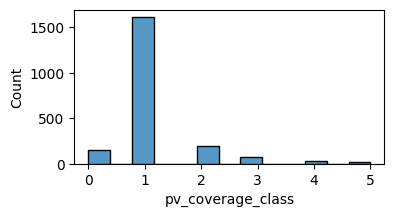

In [38]:
pv_coverage = np.array([np.mean(_mask) for _mask in train_mask_data])
pv_coverage_class = (pv_coverage * 5).astype(int) + 1 # convert coverage into integer
pv_coverage_class[pv_coverage == 0] = 0 # set samples without solar panels into special group

train_data = pd.DataFrame()

train_data["image_file_name"] = train_image_files
train_data["pv_coverage"] = pv_coverage
train_data["pv_coverage_class"] = pv_coverage_class
train_data["fold"] = -1

plt.figure(figsize=(4,2))
sns.histplot(train_data["pv_coverage_class"])

In [39]:
sgkf = StratifiedKFold(n_splits=CFG.N_folds, random_state=CFG.seed, shuffle=True)
for i, (train_index, test_index) in enumerate(sgkf.split(train_data["image_file_name"].values, train_data["pv_coverage_class"].values)):
    train_data.loc[test_index, "fold"] = i

,0,1,2,3,4,5
pv_coverage_class,0,1,2,3,4,5
valid,30,322,39,15,5,2
train,116,1292,152,60,21,11


100%|██████████| 413/413 [00:03<00:00, 127.75it/s]
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 333MB/s]


Model parameters: 21_703_697


Epoch 0 training 25/25 [LR 0.000362] - loss: 1.4681: 100%|██████████| 25/25 [00:07<00:00,  3.43it/s]



Epoch 0 train loss = 1.4681, base f1 score (0.5 threshold) = 0.1069 (best threhold: 0.22 -> f1 0.1261)


100%|██████████| 7/7 [00:00<00:00, 17.78it/s]


Epoch 0 validation loss = 1.3159, base f1 score (0.5 threshold) = 0.1547 (best threhold: 0.46 -> f1 0.1576)
New best score: 0.0000 -> 0.1576


Epoch 1 training 25/25 [LR 0.000917] - loss: 1.1718: 100%|██████████| 25/25 [00:03<00:00,  7.62it/s]



Epoch 1 train loss = 1.1718, base f1 score (0.5 threshold) = 0.2258 (best threhold: 0.53 -> f1 0.2262)


100%|██████████| 7/7 [00:00<00:00, 19.81it/s]


Epoch 1 validation loss = 1.7361, base f1 score (0.5 threshold) = 0.1792 (best threhold: 0.71 -> f1 0.1829)
New best score: 0.1576 -> 0.1829


Epoch 2 training 25/25 [LR 0.001000] - loss: 0.8043: 100%|██████████| 25/25 [00:03<00:00,  7.72it/s]



Epoch 2 train loss = 0.8043, base f1 score (0.5 threshold) = 0.3214 (best threhold: 0.37 -> f1 0.3319)


100%|██████████| 7/7 [00:00<00:00, 13.49it/s]


Epoch 2 validation loss = 0.6924, base f1 score (0.5 threshold) = 0.3396 (best threhold: 0.24 -> f1 0.3758)
New best score: 0.1829 -> 0.3758


Epoch 3 training 25/25 [LR 0.000997] - loss: 0.6166: 100%|██████████| 25/25 [00:04<00:00,  5.15it/s]



Epoch 3 train loss = 0.6166, base f1 score (0.5 threshold) = 0.3537 (best threhold: 0.2 -> f1 0.3816)


100%|██████████| 7/7 [00:00<00:00, 20.19it/s]


Epoch 3 validation loss = 0.5834, base f1 score (0.5 threshold) = 0.3197 (best threhold: 0.16 -> f1 0.4174)
New best score: 0.3758 -> 0.4174


Epoch 4 training 25/25 [LR 0.000993] - loss: 0.5255: 100%|██████████| 25/25 [00:03<00:00,  7.73it/s]



Epoch 4 train loss = 0.5255, base f1 score (0.5 threshold) = 0.3849 (best threhold: 0.15 -> f1 0.4267)


100%|██████████| 7/7 [00:00<00:00, 20.30it/s]


Epoch 4 validation loss = 0.6727, base f1 score (0.5 threshold) = 0.2380 (best threhold: 0.03 -> f1 0.3993)


,0,1,2,3,4,5
pv_coverage_class,0.0,1.000000,2.000000,3.000000,4.000000,5.000000
f1_scores,0.0,0.379101,0.785857,0.828067,0.935588,0.931926


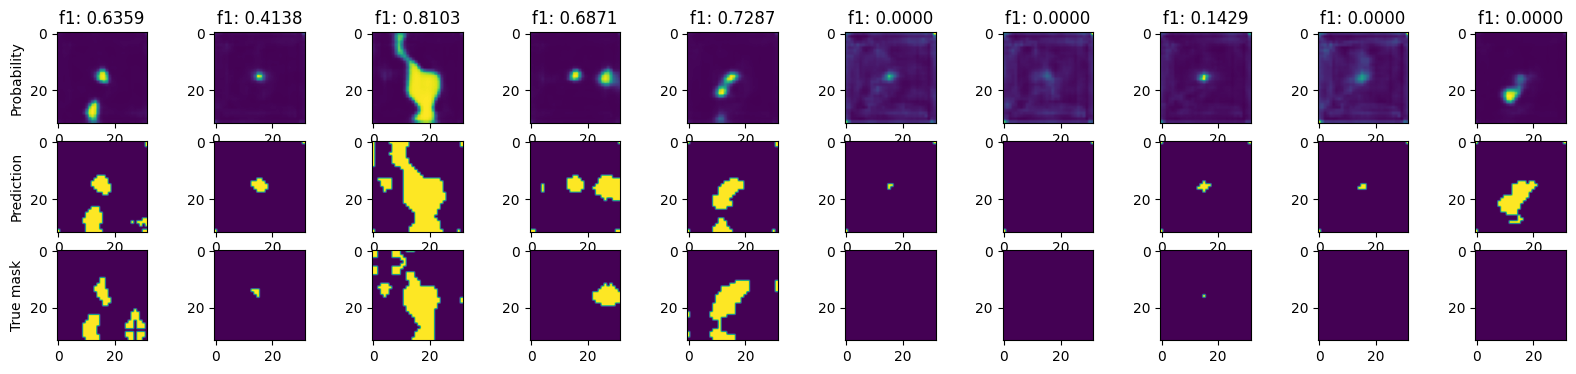

Epoch 5 training 25/25 [LR 0.000986] - loss: 0.4963: 100%|██████████| 25/25 [00:04<00:00,  5.16it/s]



Epoch 5 train loss = 0.4963, base f1 score (0.5 threshold) = 0.4139 (best threhold: 0.2 -> f1 0.4412)


100%|██████████| 7/7 [00:00<00:00, 20.04it/s]


Epoch 5 validation loss = 0.4864, base f1 score (0.5 threshold) = 0.4566 (best threhold: 0.47 -> f1 0.4609)
New best score: 0.4174 -> 0.4609


Epoch 6 training 25/25 [LR 0.000978] - loss: 0.4641: 100%|██████████| 25/25 [00:03<00:00,  7.36it/s]



Epoch 6 train loss = 0.4641, base f1 score (0.5 threshold) = 0.4278 (best threhold: 0.14 -> f1 0.4617)


100%|██████████| 7/7 [00:00<00:00, 18.54it/s]


Epoch 6 validation loss = 0.4757, base f1 score (0.5 threshold) = 0.3537 (best threhold: 0.06 -> f1 0.4603)


Epoch 7 training 25/25 [LR 0.000967] - loss: 0.4384: 100%|██████████| 25/25 [00:04<00:00,  6.20it/s]



Epoch 7 train loss = 0.4384, base f1 score (0.5 threshold) = 0.4387 (best threhold: 0.13 -> f1 0.4746)


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


Epoch 7 validation loss = 0.4539, base f1 score (0.5 threshold) = 0.4364 (best threhold: 0.16 -> f1 0.4761)
New best score: 0.4609 -> 0.4761


Epoch 8 training 25/25 [LR 0.000954] - loss: 0.4397: 100%|██████████| 25/25 [00:05<00:00,  4.83it/s]



Epoch 8 train loss = 0.4397, base f1 score (0.5 threshold) = 0.4426 (best threhold: 0.13 -> f1 0.4712)


100%|██████████| 7/7 [00:00<00:00, 10.60it/s]


Epoch 8 validation loss = 0.5407, base f1 score (0.5 threshold) = 0.2998 (best threhold: 0.03 -> f1 0.4490)


Epoch 9 training 25/25 [LR 0.000939] - loss: 0.4275: 100%|██████████| 25/25 [00:06<00:00,  3.67it/s]



Epoch 9 train loss = 0.4275, base f1 score (0.5 threshold) = 0.4553 (best threhold: 0.15 -> f1 0.4799)


100%|██████████| 7/7 [00:00<00:00,  9.99it/s]


Epoch 9 validation loss = 0.4229, base f1 score (0.5 threshold) = 0.4098 (best threhold: 0.08 -> f1 0.4985)


,0,1,2,3,4,5
pv_coverage_class,0.0,1.000000,2.000000,3.000000,4.000000,5.000000
f1_scores,0.3,0.469866,0.810209,0.875843,0.961749,0.937929


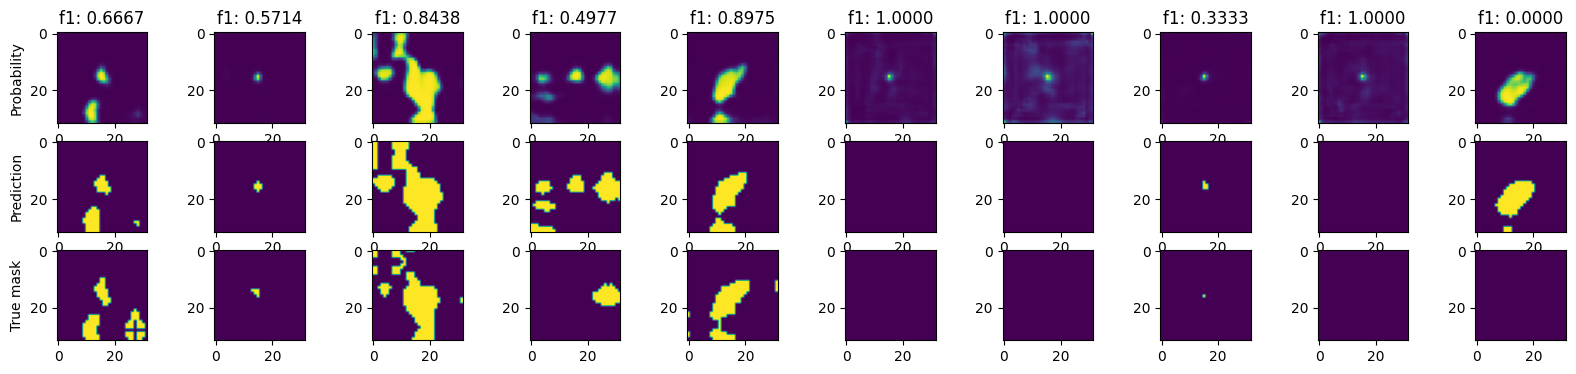

New best score: 0.4761 -> 0.4985


Epoch 10 training 25/25 [LR 0.000922] - loss: 0.4045: 100%|██████████| 25/25 [00:03<00:00,  6.56it/s]



Epoch 10 train loss = 0.4045, base f1 score (0.5 threshold) = 0.4556 (best threhold: 0.15 -> f1 0.4904)


100%|██████████| 7/7 [00:00<00:00, 13.21it/s]


Epoch 10 validation loss = 0.4170, base f1 score (0.5 threshold) = 0.4719 (best threhold: 0.33 -> f1 0.4918)


Epoch 11 training 25/25 [LR 0.000904] - loss: 0.4020: 100%|██████████| 25/25 [00:04<00:00,  5.39it/s]



Epoch 11 train loss = 0.4020, base f1 score (0.5 threshold) = 0.4601 (best threhold: 0.15 -> f1 0.4899)


100%|██████████| 7/7 [00:00<00:00, 19.22it/s]


Epoch 11 validation loss = 0.4100, base f1 score (0.5 threshold) = 0.4637 (best threhold: 0.16 -> f1 0.4926)


Epoch 12 training 25/25 [LR 0.000883] - loss: 0.3941: 100%|██████████| 25/25 [00:03<00:00,  7.23it/s]



Epoch 12 train loss = 0.3941, base f1 score (0.5 threshold) = 0.4697 (best threhold: 0.14 -> f1 0.4981)


100%|██████████| 7/7 [00:00<00:00, 18.72it/s]


Epoch 12 validation loss = 0.4486, base f1 score (0.5 threshold) = 0.3808 (best threhold: 0.05 -> f1 0.4983)


Epoch 13 training 25/25 [LR 0.000861] - loss: 0.3881: 100%|██████████| 25/25 [00:03<00:00,  6.66it/s]



Epoch 13 train loss = 0.3881, base f1 score (0.5 threshold) = 0.4709 (best threhold: 0.15 -> f1 0.5048)


100%|██████████| 7/7 [00:00<00:00, 11.79it/s]


Epoch 13 validation loss = 0.4441, base f1 score (0.5 threshold) = 0.4228 (best threhold: 0.08 -> f1 0.5072)
New best score: 0.4985 -> 0.5072


Epoch 14 training 25/25 [LR 0.000838] - loss: 0.3862: 100%|██████████| 25/25 [00:04<00:00,  5.71it/s]



Epoch 14 train loss = 0.3862, base f1 score (0.5 threshold) = 0.4851 (best threhold: 0.24 -> f1 0.5053)


100%|██████████| 7/7 [00:00<00:00, 18.67it/s]


Epoch 14 validation loss = 0.3860, base f1 score (0.5 threshold) = 0.5026 (best threhold: 0.31 -> f1 0.5207)


,0,1,2,3,4,5
pv_coverage_class,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000
f1_scores,0.333333,0.491455,0.838185,0.880302,0.966802,0.936775


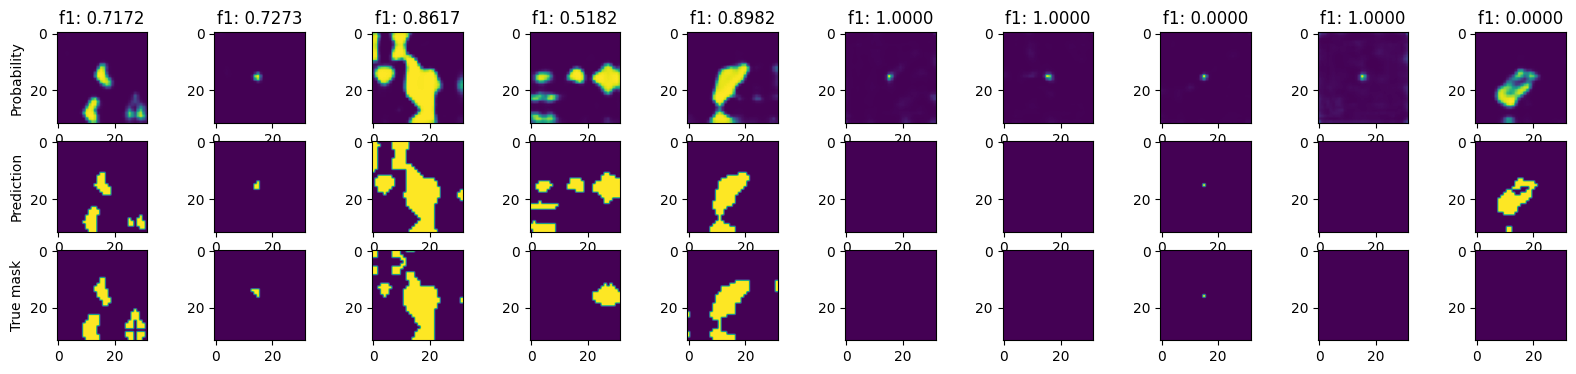

New best score: 0.5072 -> 0.5207


Epoch 15 training 25/25 [LR 0.000813] - loss: 0.3765: 100%|██████████| 25/25 [00:04<00:00,  5.71it/s]



Epoch 15 train loss = 0.3765, base f1 score (0.5 threshold) = 0.4801 (best threhold: 0.15 -> f1 0.5158)


100%|██████████| 7/7 [00:00<00:00, 11.74it/s]


Epoch 15 validation loss = 0.3997, base f1 score (0.5 threshold) = 0.4944 (best threhold: 0.37 -> f1 0.5050)


Epoch 16 training 25/25 [LR 0.000786] - loss: 0.3769: 100%|██████████| 25/25 [00:03<00:00,  7.20it/s]



Epoch 16 train loss = 0.3769, base f1 score (0.5 threshold) = 0.4816 (best threhold: 0.13 -> f1 0.5120)


100%|██████████| 7/7 [00:00<00:00, 17.90it/s]


Epoch 16 validation loss = 0.3861, base f1 score (0.5 threshold) = 0.4701 (best threhold: 0.11 -> f1 0.5175)


Epoch 17 training 25/25 [LR 0.000758] - loss: 0.3775: 100%|██████████| 25/25 [00:03<00:00,  7.35it/s]



Epoch 17 train loss = 0.3775, base f1 score (0.5 threshold) = 0.4915 (best threhold: 0.15 -> f1 0.5155)


100%|██████████| 7/7 [00:00<00:00, 18.22it/s]


Epoch 17 validation loss = 0.4470, base f1 score (0.5 threshold) = 0.4119 (best threhold: 0.08 -> f1 0.4556)


Epoch 18 training 25/25 [LR 0.000729] - loss: 0.3664: 100%|██████████| 25/25 [00:05<00:00,  4.92it/s]



Epoch 18 train loss = 0.3664, base f1 score (0.5 threshold) = 0.4843 (best threhold: 0.17 -> f1 0.5112)


100%|██████████| 7/7 [00:00<00:00, 17.17it/s]


Epoch 18 validation loss = 0.3692, base f1 score (0.5 threshold) = 0.4820 (best threhold: 0.1 -> f1 0.5164)


Epoch 19 training 25/25 [LR 0.000700] - loss: 0.3642: 100%|██████████| 25/25 [00:04<00:00,  5.66it/s]



Epoch 19 train loss = 0.3642, base f1 score (0.5 threshold) = 0.4877 (best threhold: 0.16 -> f1 0.5155)


100%|██████████| 7/7 [00:00<00:00, 13.24it/s]


Epoch 19 validation loss = 0.4065, base f1 score (0.5 threshold) = 0.4431 (best threhold: 0.13 -> f1 0.4847)


,0,1,2,3,4,5
pv_coverage_class,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000
f1_scores,0.333333,0.445569,0.852803,0.893972,0.951846,0.940807


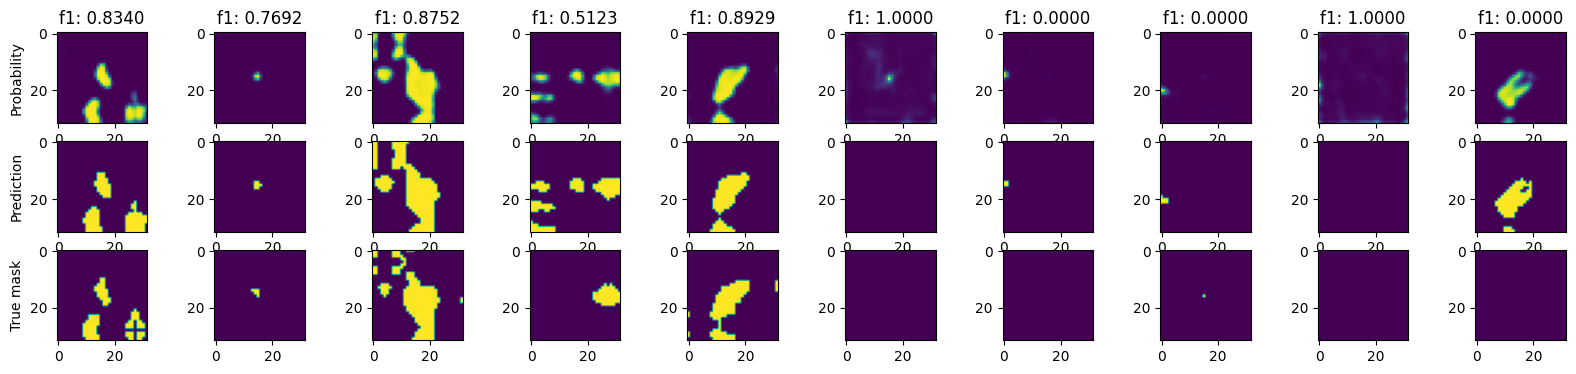

Epoch 20 training 25/25 [LR 0.000669] - loss: 0.3689: 100%|██████████| 25/25 [00:05<00:00,  4.95it/s]



Epoch 20 train loss = 0.3689, base f1 score (0.5 threshold) = 0.4857 (best threhold: 0.2 -> f1 0.5200)


100%|██████████| 7/7 [00:00<00:00, 18.30it/s]


Epoch 20 validation loss = 0.3660, base f1 score (0.5 threshold) = 0.4622 (best threhold: 0.12 -> f1 0.5263)
New best score: 0.5207 -> 0.5263


Epoch 21 training 25/25 [LR 0.000637] - loss: 0.3569: 100%|██████████| 25/25 [00:03<00:00,  7.15it/s]



Epoch 21 train loss = 0.3569, base f1 score (0.5 threshold) = 0.4943 (best threhold: 0.19 -> f1 0.5227)


100%|██████████| 7/7 [00:00<00:00, 18.26it/s]


Epoch 21 validation loss = 0.3746, base f1 score (0.5 threshold) = 0.5135 (best threhold: 0.34 -> f1 0.5275)
New best score: 0.5263 -> 0.5275


Epoch 22 training 25/25 [LR 0.000605] - loss: 0.3559: 100%|██████████| 25/25 [00:03<00:00,  7.07it/s]



Epoch 22 train loss = 0.3559, base f1 score (0.5 threshold) = 0.4975 (best threhold: 0.13 -> f1 0.5269)


100%|██████████| 7/7 [00:00<00:00, 12.84it/s]


Epoch 22 validation loss = 0.3698, base f1 score (0.5 threshold) = 0.5078 (best threhold: 0.3 -> f1 0.5186)


Epoch 23 training 25/25 [LR 0.000573] - loss: 0.3464: 100%|██████████| 25/25 [00:05<00:00,  4.90it/s]



Epoch 23 train loss = 0.3464, base f1 score (0.5 threshold) = 0.4968 (best threhold: 0.14 -> f1 0.5220)


100%|██████████| 7/7 [00:00<00:00, 19.06it/s]


Epoch 23 validation loss = 0.3969, base f1 score (0.5 threshold) = 0.4011 (best threhold: 0.05 -> f1 0.5277)
New best score: 0.5275 -> 0.5277


Epoch 24 training 25/25 [LR 0.000540] - loss: 0.3554: 100%|██████████| 25/25 [00:03<00:00,  7.17it/s]



Epoch 24 train loss = 0.3554, base f1 score (0.5 threshold) = 0.4969 (best threhold: 0.18 -> f1 0.5253)


100%|██████████| 7/7 [00:00<00:00, 18.01it/s]


Epoch 24 validation loss = 0.4020, base f1 score (0.5 threshold) = 0.3768 (best threhold: 0.04 -> f1 0.5268)


,0,1,2,3,4,5
pv_coverage_class,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000
f1_scores,0.266667,0.504052,0.842555,0.890793,0.968553,0.943349


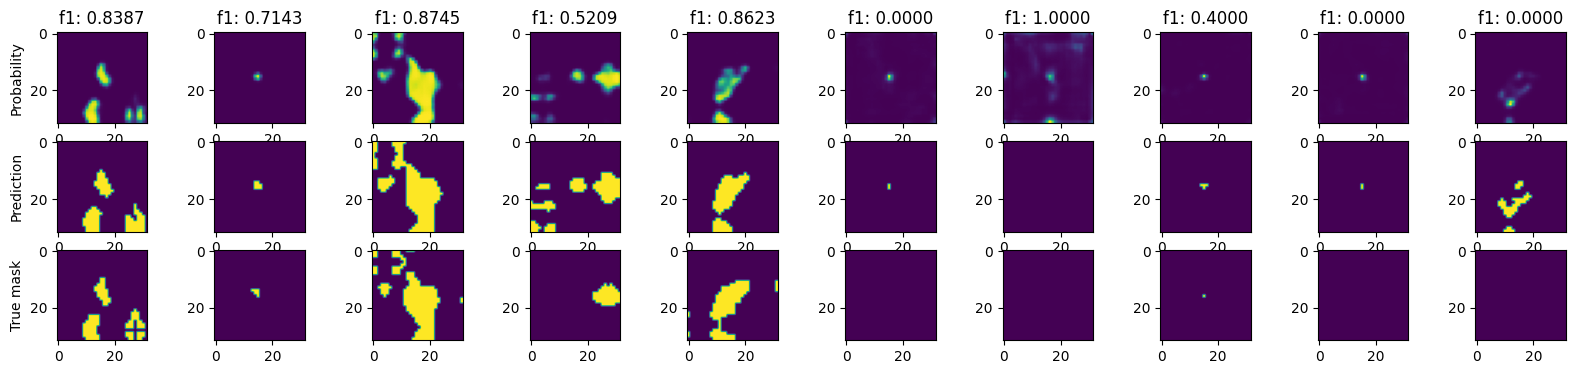

Epoch 25 training 25/25 [LR 0.000507] - loss: 0.3443: 100%|██████████| 25/25 [00:04<00:00,  5.10it/s]



Epoch 25 train loss = 0.3443, base f1 score (0.5 threshold) = 0.5074 (best threhold: 0.22 -> f1 0.5264)


100%|██████████| 7/7 [00:00<00:00, 10.41it/s]


Epoch 25 validation loss = 0.3636, base f1 score (0.5 threshold) = 0.4349 (best threhold: 0.07 -> f1 0.5284)
New best score: 0.5277 -> 0.5284


Epoch 26 training 25/25 [LR 0.000474] - loss: 0.3423: 100%|██████████| 25/25 [00:03<00:00,  7.21it/s]



Epoch 26 train loss = 0.3423, base f1 score (0.5 threshold) = 0.5058 (best threhold: 0.13 -> f1 0.5315)


100%|██████████| 7/7 [00:00<00:00, 19.24it/s]


Epoch 26 validation loss = 0.3544, base f1 score (0.5 threshold) = 0.4910 (best threhold: 0.12 -> f1 0.5331)
New best score: 0.5284 -> 0.5331


Epoch 27 training 25/25 [LR 0.000441] - loss: 0.3422: 100%|██████████| 25/25 [00:03<00:00,  6.90it/s]



Epoch 27 train loss = 0.3422, base f1 score (0.5 threshold) = 0.5028 (best threhold: 0.1 -> f1 0.5321)


100%|██████████| 7/7 [00:00<00:00, 12.50it/s]


Epoch 27 validation loss = 0.3519, base f1 score (0.5 threshold) = 0.5421 (best threhold: 0.5 -> f1 0.5421)
New best score: 0.5331 -> 0.5421


Epoch 28 training 25/25 [LR 0.000408] - loss: 0.3495: 100%|██████████| 25/25 [00:04<00:00,  5.36it/s]



Epoch 28 train loss = 0.3495, base f1 score (0.5 threshold) = 0.5162 (best threhold: 0.22 -> f1 0.5343)


100%|██████████| 7/7 [00:00<00:00, 18.08it/s]


Epoch 28 validation loss = 0.3791, base f1 score (0.5 threshold) = 0.5220 (best threhold: 0.45 -> f1 0.5287)


Epoch 29 training 25/25 [LR 0.000376] - loss: 0.3370: 100%|██████████| 25/25 [00:03<00:00,  6.91it/s]



Epoch 29 train loss = 0.3370, base f1 score (0.5 threshold) = 0.5070 (best threhold: 0.21 -> f1 0.5314)


100%|██████████| 7/7 [00:00<00:00, 19.14it/s]


Epoch 29 validation loss = 0.3463, base f1 score (0.5 threshold) = 0.5374 (best threhold: 0.34 -> f1 0.5493)


,0,1,2,3,4,5
pv_coverage_class,0.000000,1.000000,2.000000,3.000000,4.000000,5.0000
f1_scores,0.333333,0.524073,0.857124,0.898001,0.977813,0.9432


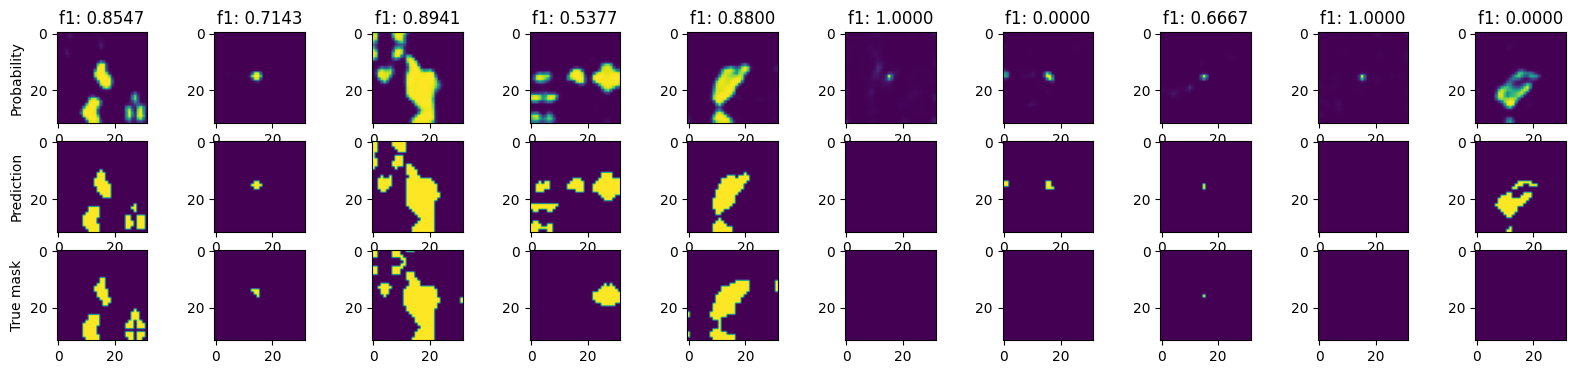

New best score: 0.5421 -> 0.5493


Epoch 30 training 25/25 [LR 0.000344] - loss: 0.3333: 100%|██████████| 25/25 [00:05<00:00,  4.99it/s]



Epoch 30 train loss = 0.3333, base f1 score (0.5 threshold) = 0.5087 (best threhold: 0.11 -> f1 0.5333)


100%|██████████| 7/7 [00:00<00:00, 18.10it/s]


Epoch 30 validation loss = 0.3523, base f1 score (0.5 threshold) = 0.5314 (best threhold: 0.28 -> f1 0.5460)


Epoch 31 training 25/25 [LR 0.000313] - loss: 0.3345: 100%|██████████| 25/25 [00:03<00:00,  6.85it/s]



Epoch 31 train loss = 0.3345, base f1 score (0.5 threshold) = 0.5178 (best threhold: 0.21 -> f1 0.5403)


100%|██████████| 7/7 [00:00<00:00, 18.23it/s]


Epoch 31 validation loss = 0.3724, base f1 score (0.5 threshold) = 0.4436 (best threhold: 0.05 -> f1 0.5460)


Epoch 32 training 25/25 [LR 0.000283] - loss: 0.3284: 100%|██████████| 25/25 [00:03<00:00,  6.55it/s]



Epoch 32 train loss = 0.3284, base f1 score (0.5 threshold) = 0.5174 (best threhold: 0.21 -> f1 0.5384)


100%|██████████| 7/7 [00:00<00:00, 11.76it/s]


Epoch 32 validation loss = 0.3445, base f1 score (0.5 threshold) = 0.5233 (best threhold: 0.27 -> f1 0.5430)


Epoch 33 training 25/25 [LR 0.000254] - loss: 0.3308: 100%|██████████| 25/25 [00:04<00:00,  5.02it/s]



Epoch 33 train loss = 0.3308, base f1 score (0.5 threshold) = 0.5090 (best threhold: 0.22 -> f1 0.5382)


100%|██████████| 7/7 [00:00<00:00, 15.63it/s]


Epoch 33 validation loss = 0.3728, base f1 score (0.5 threshold) = 0.5439 (best threhold: 0.59 -> f1 0.5459)


Epoch 34 training 25/25 [LR 0.000225] - loss: 0.3299: 100%|██████████| 25/25 [00:03<00:00,  6.75it/s]



Epoch 34 train loss = 0.3299, base f1 score (0.5 threshold) = 0.5078 (best threhold: 0.17 -> f1 0.5388)


100%|██████████| 7/7 [00:00<00:00, 18.56it/s]


Epoch 34 validation loss = 0.3574, base f1 score (0.5 threshold) = 0.5029 (best threhold: 0.15 -> f1 0.5514)


,0,1,2,3,4,5
pv_coverage_class,0.000000,1.000000,2.000000,3.000000,4.00000,5.000000
f1_scores,0.433333,0.521361,0.848474,0.824572,0.96917,0.940933


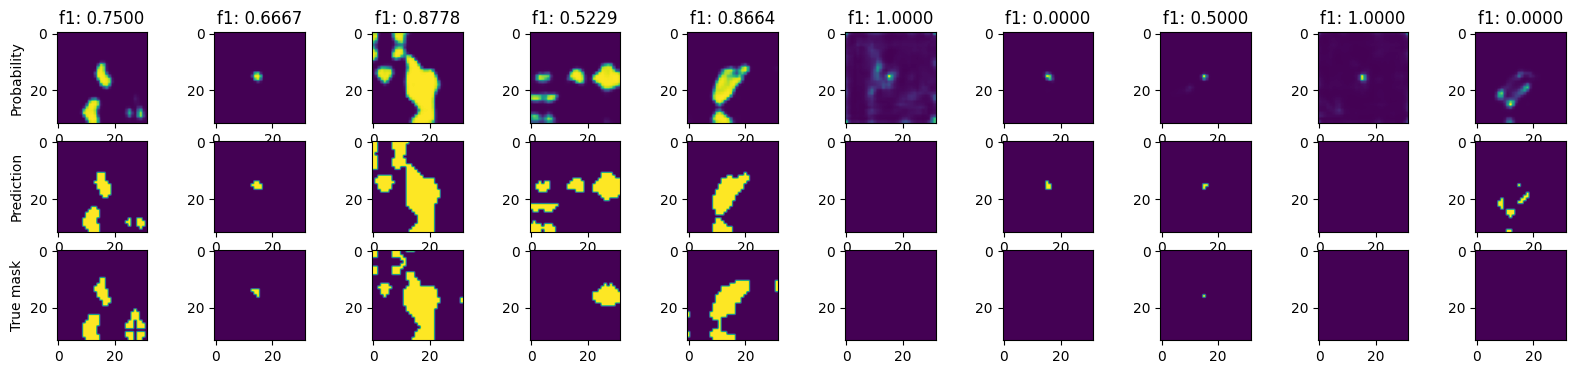

New best score: 0.5493 -> 0.5514


Epoch 35 training 25/25 [LR 0.000198] - loss: 0.3254: 100%|██████████| 25/25 [00:07<00:00,  3.45it/s]



Epoch 35 train loss = 0.3254, base f1 score (0.5 threshold) = 0.5144 (best threhold: 0.15 -> f1 0.5381)


100%|██████████| 7/7 [00:01<00:00,  3.58it/s]


Epoch 35 validation loss = 0.3361, base f1 score (0.5 threshold) = 0.5150 (best threhold: 0.14 -> f1 0.5500)


Epoch 36 training 25/25 [LR 0.000173] - loss: 0.3242: 100%|██████████| 25/25 [00:07<00:00,  3.53it/s]



Epoch 36 train loss = 0.3242, base f1 score (0.5 threshold) = 0.5155 (best threhold: 0.15 -> f1 0.5433)


100%|██████████| 7/7 [00:00<00:00, 18.11it/s]


Epoch 36 validation loss = 0.3568, base f1 score (0.5 threshold) = 0.4819 (best threhold: 0.07 -> f1 0.5442)


Epoch 37 training 25/25 [LR 0.000148] - loss: 0.3282: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s]



Epoch 37 train loss = 0.3282, base f1 score (0.5 threshold) = 0.5222 (best threhold: 0.27 -> f1 0.5486)


100%|██████████| 7/7 [00:00<00:00, 10.08it/s]


Epoch 37 validation loss = 0.3338, base f1 score (0.5 threshold) = 0.5167 (best threhold: 0.15 -> f1 0.5529)
New best score: 0.5514 -> 0.5529


Epoch 38 training 25/25 [LR 0.000126] - loss: 0.3284: 100%|██████████| 25/25 [00:05<00:00,  4.52it/s]



Epoch 38 train loss = 0.3284, base f1 score (0.5 threshold) = 0.5188 (best threhold: 0.14 -> f1 0.5441)


100%|██████████| 7/7 [00:00<00:00, 18.70it/s]


Epoch 38 validation loss = 0.3406, base f1 score (0.5 threshold) = 0.5133 (best threhold: 0.14 -> f1 0.5515)


Epoch 39 training 25/25 [LR 0.000105] - loss: 0.3296: 100%|██████████| 25/25 [00:03<00:00,  6.96it/s]



Epoch 39 train loss = 0.3296, base f1 score (0.5 threshold) = 0.5179 (best threhold: 0.14 -> f1 0.5431)


100%|██████████| 7/7 [00:00<00:00, 18.36it/s]


Epoch 39 validation loss = 0.3552, base f1 score (0.5 threshold) = 0.5146 (best threhold: 0.16 -> f1 0.5464)


,0,1,2,3,4,5
pv_coverage_class,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000
f1_scores,0.266667,0.529693,0.849212,0.831916,0.964257,0.942195


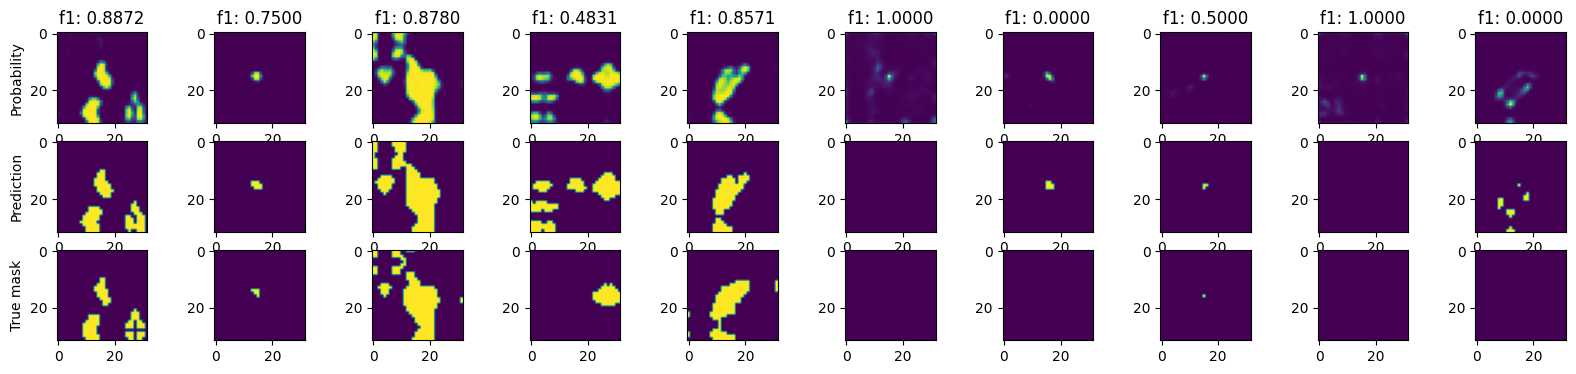

Epoch 40 training 25/25 [LR 0.000085] - loss: 0.3267: 100%|██████████| 25/25 [00:04<00:00,  5.06it/s]



Epoch 40 train loss = 0.3267, base f1 score (0.5 threshold) = 0.5145 (best threhold: 0.13 -> f1 0.5398)


100%|██████████| 7/7 [00:00<00:00, 17.24it/s]


Epoch 40 validation loss = 0.3369, base f1 score (0.5 threshold) = 0.5262 (best threhold: 0.18 -> f1 0.5523)


Epoch 41 training 25/25 [LR 0.000068] - loss: 0.3240: 100%|██████████| 25/25 [00:03<00:00,  6.83it/s]



Epoch 41 train loss = 0.3240, base f1 score (0.5 threshold) = 0.5193 (best threhold: 0.19 -> f1 0.5462)


100%|██████████| 7/7 [00:00<00:00, 18.43it/s]


Epoch 41 validation loss = 0.3381, base f1 score (0.5 threshold) = 0.5127 (best threhold: 0.2 -> f1 0.5517)


Epoch 42 training 25/25 [LR 0.000052] - loss: 0.3199: 100%|██████████| 25/25 [00:03<00:00,  6.63it/s]



Epoch 42 train loss = 0.3199, base f1 score (0.5 threshold) = 0.5173 (best threhold: 0.2 -> f1 0.5445)


100%|██████████| 7/7 [00:00<00:00, 12.04it/s]


Epoch 42 validation loss = 0.3406, base f1 score (0.5 threshold) = 0.5263 (best threhold: 0.24 -> f1 0.5514)


Epoch 43 training 25/25 [LR 0.000038] - loss: 0.3176: 100%|██████████| 25/25 [00:05<00:00,  4.82it/s]



Epoch 43 train loss = 0.3176, base f1 score (0.5 threshold) = 0.5230 (best threhold: 0.17 -> f1 0.5477)


100%|██████████| 7/7 [00:00<00:00, 17.77it/s]


Epoch 43 validation loss = 0.3390, base f1 score (0.5 threshold) = 0.5243 (best threhold: 0.22 -> f1 0.5489)


Epoch 44 training 25/25 [LR 0.000027] - loss: 0.3200: 100%|██████████| 25/25 [00:03<00:00,  6.90it/s]



Epoch 44 train loss = 0.3200, base f1 score (0.5 threshold) = 0.5260 (best threhold: 0.15 -> f1 0.5515)


100%|██████████| 7/7 [00:00<00:00, 17.10it/s]


Epoch 44 validation loss = 0.3348, base f1 score (0.5 threshold) = 0.5341 (best threhold: 0.24 -> f1 0.5520)


,0,1,2,3,4,5
pv_coverage_class,0.0,1.000000,2.000000,3.00000,4.000000,5.000000
f1_scores,0.3,0.529977,0.861954,0.89814,0.968775,0.943326


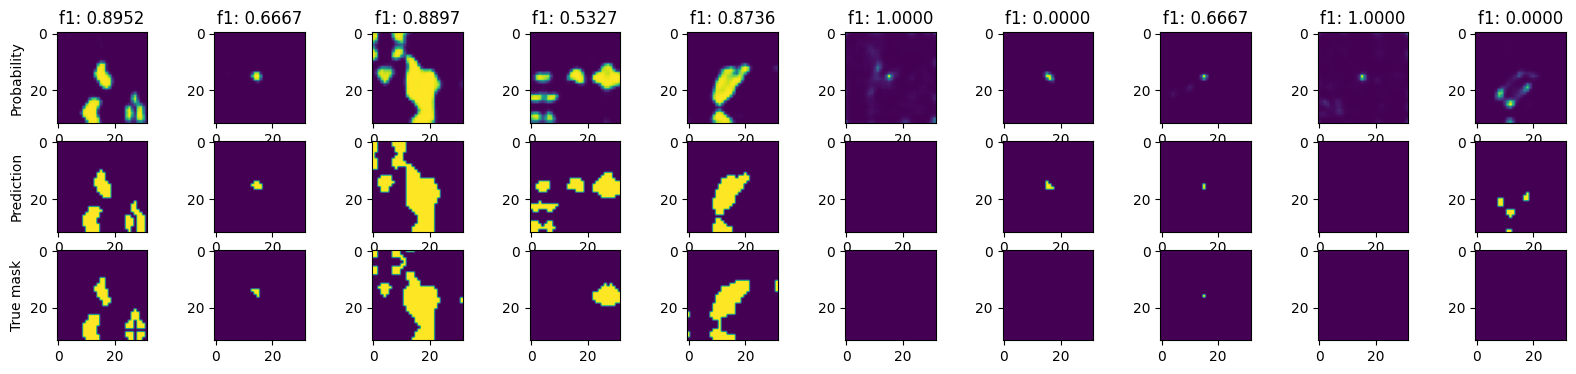

Epoch 45 training 25/25 [LR 0.000017] - loss: 0.3132: 100%|██████████| 25/25 [00:05<00:00,  4.90it/s]



Epoch 45 train loss = 0.3132, base f1 score (0.5 threshold) = 0.5224 (best threhold: 0.16 -> f1 0.5512)


100%|██████████| 7/7 [00:00<00:00, 17.71it/s]


Epoch 45 validation loss = 0.3407, base f1 score (0.5 threshold) = 0.5165 (best threhold: 0.2 -> f1 0.5518)


Epoch 46 training 25/25 [LR 0.000010] - loss: 0.3219: 100%|██████████| 25/25 [00:03<00:00,  6.72it/s]



Epoch 46 train loss = 0.3219, base f1 score (0.5 threshold) = 0.5177 (best threhold: 0.16 -> f1 0.5483)


100%|██████████| 7/7 [00:00<00:00, 17.90it/s]


Epoch 46 validation loss = 0.3413, base f1 score (0.5 threshold) = 0.5143 (best threhold: 0.21 -> f1 0.5510)


Epoch 47 training 25/25 [LR 0.000004] - loss: 0.3172: 100%|██████████| 25/25 [00:03<00:00,  6.72it/s]



Epoch 47 train loss = 0.3172, base f1 score (0.5 threshold) = 0.5253 (best threhold: 0.17 -> f1 0.5487)


100%|██████████| 7/7 [00:00<00:00, 12.00it/s]


Epoch 47 validation loss = 0.3423, base f1 score (0.5 threshold) = 0.5129 (best threhold: 0.23 -> f1 0.5492)


Epoch 48 training 25/25 [LR 0.000001] - loss: 0.3212: 100%|██████████| 25/25 [00:05<00:00,  4.82it/s]



Epoch 48 train loss = 0.3212, base f1 score (0.5 threshold) = 0.5222 (best threhold: 0.19 -> f1 0.5468)


100%|██████████| 7/7 [00:00<00:00, 18.33it/s]


Epoch 48 validation loss = 0.3419, base f1 score (0.5 threshold) = 0.5114 (best threhold: 0.19 -> f1 0.5521)


Epoch 49 training 25/25 [LR 0.000000] - loss: 0.3203: 100%|██████████| 25/25 [00:03<00:00,  6.63it/s]



Epoch 49 train loss = 0.3203, base f1 score (0.5 threshold) = 0.5224 (best threhold: 0.19 -> f1 0.5502)


100%|██████████| 7/7 [00:00<00:00, 18.56it/s]


Epoch 49 validation loss = 0.3417, base f1 score (0.5 threshold) = 0.5100 (best threhold: 0.18 -> f1 0.5527)


,0,1,2,3,4,5
pv_coverage_class,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000
f1_scores,0.333333,0.528016,0.860891,0.896072,0.965462,0.944625


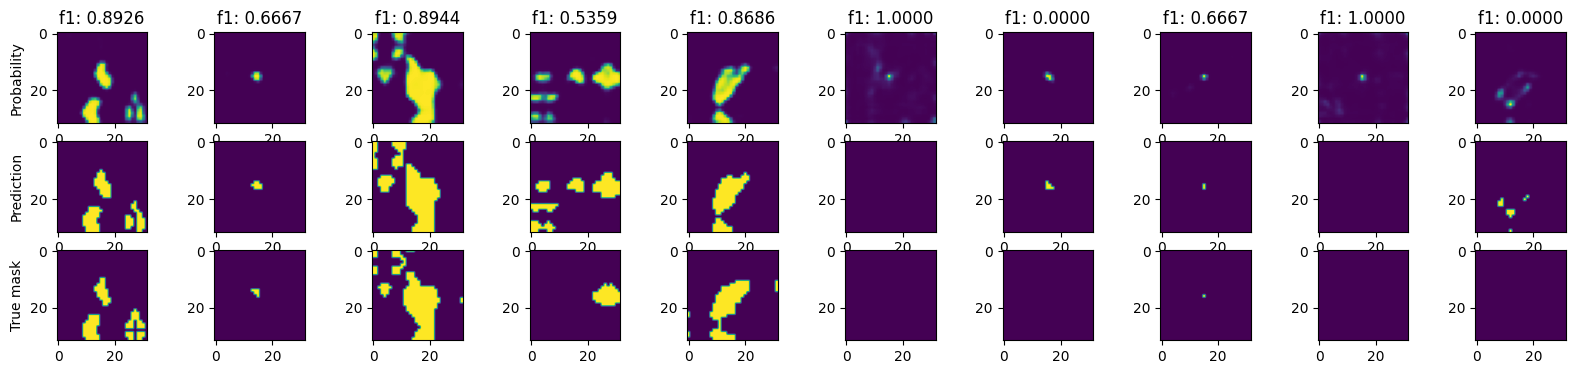

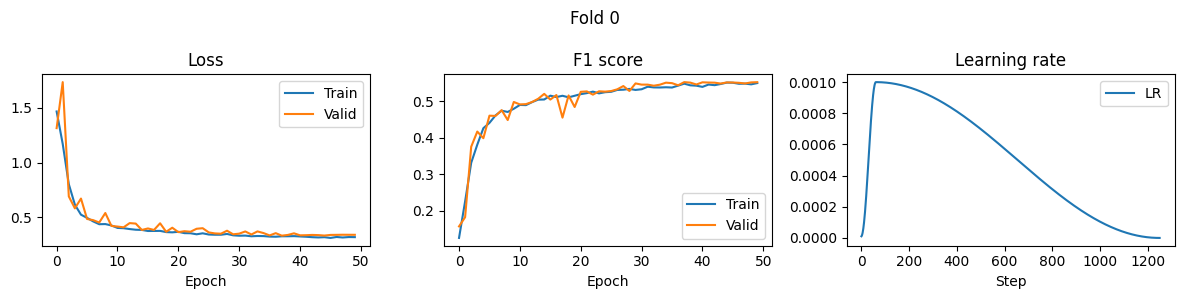

In [40]:
for FOLD in CFG.train_folds:

    # seed_everything(CFG.seed)

    # PREPARE DATA
    fold_train_data = train_data[train_data["fold"] != FOLD].reset_index(drop=True)
    fold_valid_data = train_data[train_data["fold"] == FOLD].reset_index(drop=True)

    display(
        pd.merge(
            fold_valid_data.groupby(by=["pv_coverage_class"])["image_file_name"].count().rename("valid").reset_index(),
            fold_train_data.groupby(by=["pv_coverage_class"])["image_file_name"].count().rename("train").reset_index(),
             on="pv_coverage_class", how="left").T,)


    train_image_data, train_mask_data = load_image_masks(TRAIN_DATA_FOLDER, fold_train_data.image_file_name)
    valid_image_data, valid_mask_data = load_image_masks(TRAIN_DATA_FOLDER, fold_valid_data.image_file_name)

    train_dataset = ImageTrainDataset(train_image_data, train_mask_data, transforms=train_transforms)
    valid_dataset = ImageTrainDataset(valid_image_data, valid_mask_data, transforms=val_transforms)

    train_loader = DataLoader(
            train_dataset,
            batch_size=CFG.batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=False,
            drop_last=True
        )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        drop_last=False,
    )

    # PREPARE MODEL, OPTIMIZER AND SCHEDULER

    model = smp.MAnet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=12, classes=1)
    model = model.to(CFG.device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):_}")

    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,max_lr=CFG.lr, total_steps=CFG.epochs * len(train_loader),
        div_factor=1e2, final_div_factor=1e3, pct_start=0.05
        )


    # TRAIN FOLD
    learning_rate_history = []
    train_loss_history = []
    train_score_history = []
    val_loss_history = []
    val_score_history = []

    best_score = 0
    for epoch in range(0, CFG.epochs):
        train_loss, train_score, train_lr = train_epoch(CFG, model, train_loader, optimizer, scheduler, epoch)
        train_loss_history.append(train_loss)
        train_score_history.append(train_score)
        learning_rate_history.extend(train_lr)

        val_loss, val_score = evaluate_model(CFG, model, valid_loader, epoch)
        val_loss_history.append(val_loss)
        val_score_history.append(val_score)

        if (val_score > best_score):
            print(f"New best score: {best_score:.4f} -> {val_score:.4f}")
            best_score = val_score
            torch.save(model.state_dict(), f'/home/best_model_fold_{FOLD}.pth')

    # plot train and validation loss, score and LR
    fig, axes = plt.subplots(1,3, figsize=(12,3))
    axes[0].plot(train_loss_history, label="Train")
    axes[0].plot(val_loss_history, label="Valid")
    axes[0].title.set_text("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].legend()

    axes[1].plot(train_score_history, label="Train")
    axes[1].plot(val_score_history, label="Valid")
    axes[1].title.set_text("F1 score")
    axes[1].set_xlabel("Epoch")
    axes[1].legend()

    axes[2].plot(learning_rate_history, label="LR")
    axes[2].legend()
    axes[2].title.set_text("Learning rate")
    axes[2].set_xlabel("Step")
    fig.suptitle(f"Fold {FOLD}")
    fig.tight_layout()
    plt.show()

## **Inference**

In [52]:
os.makedirs('/content/drive/MyDrive/Solar panel detection/output', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Solar panel detection/submission', exist_ok=True)

In [53]:
test_image_files = os.listdir(f'{TEST_DATA_FOLDER}')   #[:100]
test_image_data = []

for fn in tqdm(test_image_files):
    postfix = fn.split("_")[3]
    test_image_data.append(tifffile.imread(f"{TEST_DATA_FOLDER}{fn}"))

100%|██████████| 2066/2066 [00:26<00:00, 77.87it/s] 


In [54]:
from torch.utils.data import DataLoader, Dataset

# pad image with reflect
test_image_transforms = v2.Compose([
    v2.ToImage(),
    v2.Pad((6,6), padding_mode="reflect"),
])

# pad masks with constant so we can easily detect which part was padded
test_mask_transforms = v2.Compose([
    v2.ToImage(),
    v2.Pad((6,6), padding_mode="constant", fill=0),
])

test_transforms = v2.Compose([
    v2.CenterCrop((32,32)),
    v2.ToDtype(torch.float32, scale=False),  # Normalize expects float input
])

class ImageTestDataset(Dataset):
    def __init__(
        self,
        file_names,
        images,
        transforms=None,
    ):
        self.file_names = file_names
        self.images = images

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        image = self.images[index] # scale by scaling factor
        mask = np.ones_like(image)

        image = test_image_transforms(image)
        mask = test_mask_transforms(mask)

        image, mask = test_transforms(image, mask)

        return {"image": image,
                "mask": mask[0, :],
                "shape": image.shape,
                "file_name": self.file_names[index],
                }

ds = ImageTestDataset(test_image_files, test_image_data)
d = ds.__getitem__(0)
print(d["image"].shape, d["mask"].shape, d["shape"], d["file_name"])

torch.Size([12, 32, 32]) torch.Size([32, 32]) torch.Size([12, 32, 32]) evaluation_s2_image_1958.tif


In [55]:
def inference(cfg, model, data_loader):
    model.eval()
    mask_predictions = []
    padding_masks = []

    total_len = len(data_loader)
    tk0 = tqdm(enumerate(data_loader), total=total_len)
    for step, data in tk0:
        input = data["image"].to(cfg.device, non_blocking=True)

        with torch.no_grad():
            logits = model(input)

        padding_masks.append(data["mask"])
        mask_predictions.append(logits.detach().cpu())

    padding_masks = torch.cat(padding_masks, dim=0)
    mask_predictions = F.sigmoid(torch.cat(mask_predictions, dim=0))
    return mask_predictions, padding_masks

In [56]:
test_dataset = ImageTestDataset(test_image_files, test_image_data)
test_loader = DataLoader(
    test_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    drop_last=False,
)

In [57]:
seed_everything(CFG.seed)

test_mask_predictions = []
test_padding_masks = []

for FOLD in CFG.train_folds:
    print("Inference for fold:", FOLD)
    model = smp.MAnet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=12, classes=1)
    model = model.to(CFG.device)

    valid_image_data, valid_mask_data = load_image_masks(TRAIN_DATA_FOLDER, train_data[train_data["fold"] == FOLD].image_file_name)
    valid_dataset = ImageTrainDataset(valid_image_data, valid_mask_data, transforms=val_transforms)

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        drop_last=False,
    )

    model.load_state_dict(torch.load(f"/home/best_model_fold_{FOLD}.pth", map_location=CFG.device))
    val_loss, val_score = evaluate_model(CFG, model, valid_loader, epoch=0)
    predictions, padding_masks = inference(CFG, model, test_loader)

    test_mask_predictions.append(predictions)
    test_padding_masks.append(padding_masks)

# Average predictions over folds
if (len(CFG.train_folds) > 1):
    test_mask_predictions = torch.stack(test_mask_predictions, axis=-1).mean(axis=-1)
    test_padding_masks = torch.stack(test_padding_masks, axis=-1).mean(axis=-1)
else:
    test_mask_predictions = test_mask_predictions[0]
    test_padding_masks = test_padding_masks[0]

Inference for fold: 0


100%|██████████| 7/7 [00:00<00:00, 17.48it/s]


Epoch 0 validation loss = 0.3338, base f1 score (0.5 threshold) = 0.5167 (best threhold: 0.15 -> f1 0.5529)


100%|██████████| 33/33 [00:01<00:00, 18.39it/s]


## **predicted mask**

In [59]:
print(test_mask_predictions.shape)
assert test_mask_predictions.shape[0] == 2066
assert test_mask_predictions.shape[1] == 1
assert test_mask_predictions.shape[2] == 32
assert test_mask_predictions.shape[3] == 32

torch.Size([2066, 1, 32, 32])


In [60]:
THRESHOLD = 0.17

target_sizes = [np.shape(im) for im in test_image_data]

for file_name, target_size, mask_prediction, padding_mask in zip(test_image_files, target_sizes, test_mask_predictions, test_padding_masks):
    mask_prediction = mask_prediction > THRESHOLD
    # remove padding and reshape prediction to correct size
    padding_mask = padding_mask > 0
    mask_prediction = torch.masked_select(mask_prediction, padding_mask).reshape(target_size[:2]).numpy().astype(np.uint8)
    #print(mask_prediction.shape)

    tifffile.imwrite('/content/drive/MyDrive/Solar panel detection/submission/'  + file_name.replace("s2_image", "mask"), mask_prediction)

In [61]:
import glob
print(len(glob.glob("/content/drive/MyDrive/Solar panel detection/submission/*")))

2067


In [62]:
!cd '/content/drive/MyDrive/Solar panel detection/submission' && zip -qq -r '/content/drive/MyDrive/Solar panel detection/submission/submission.zip'  *.tif

In [63]:
from google.colab import files
files.download('/content/drive/MyDrive/Solar panel detection/submission/submission.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>